Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/11 21:27:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

Executors: 2, Worker nodes: 2


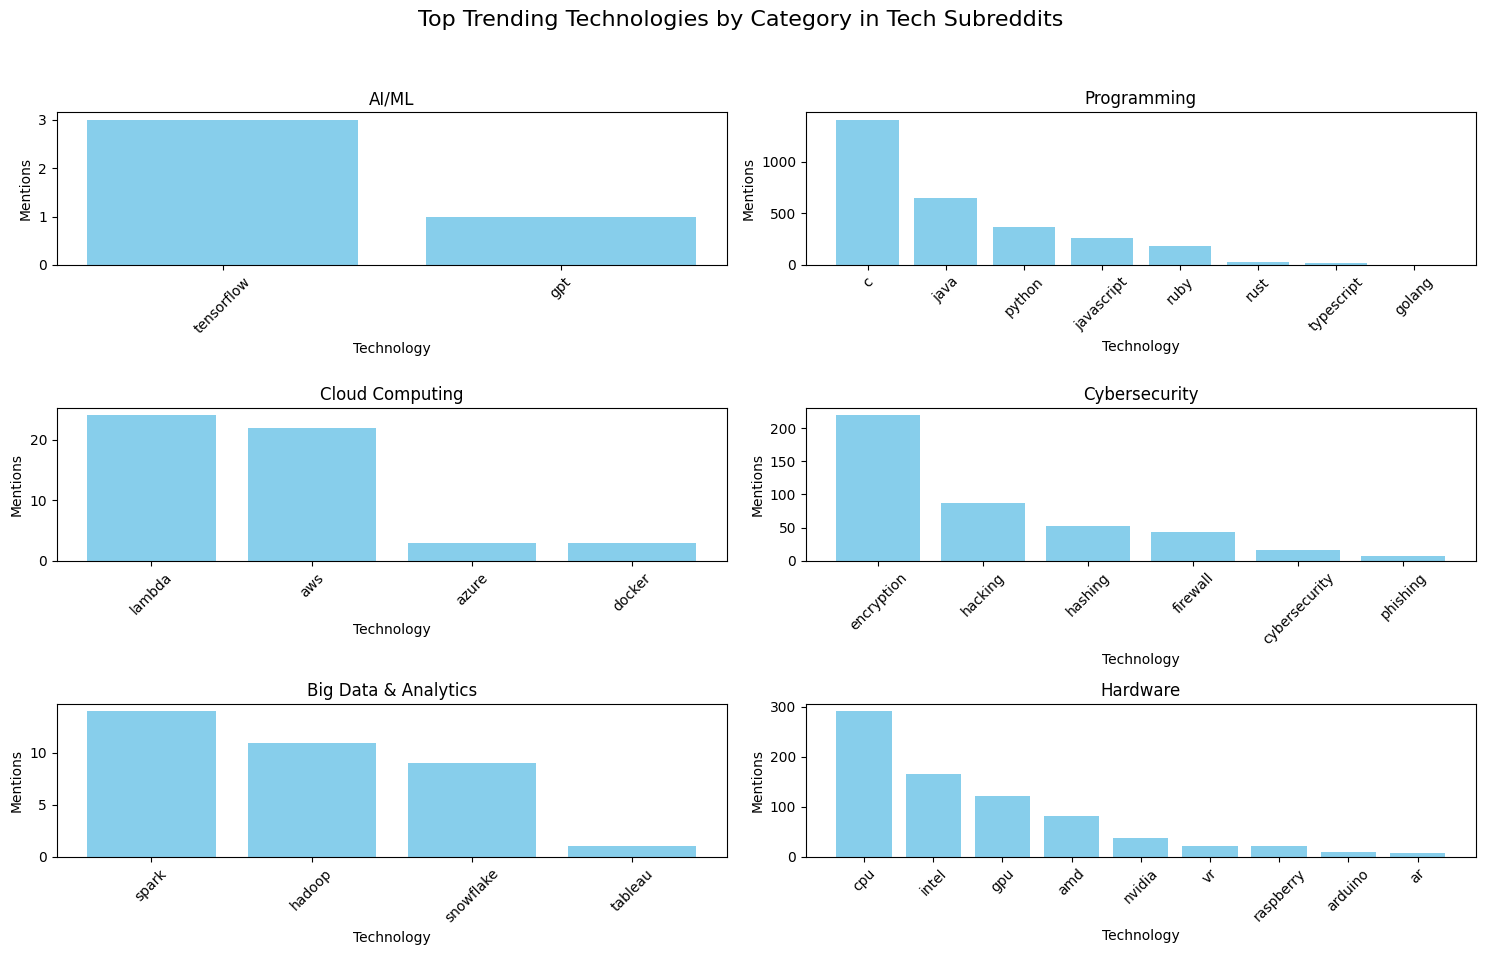

Execution Time with 2 executors: 264.59 seconds


Partitions used: 1


Executors: 4, Worker nodes: 4


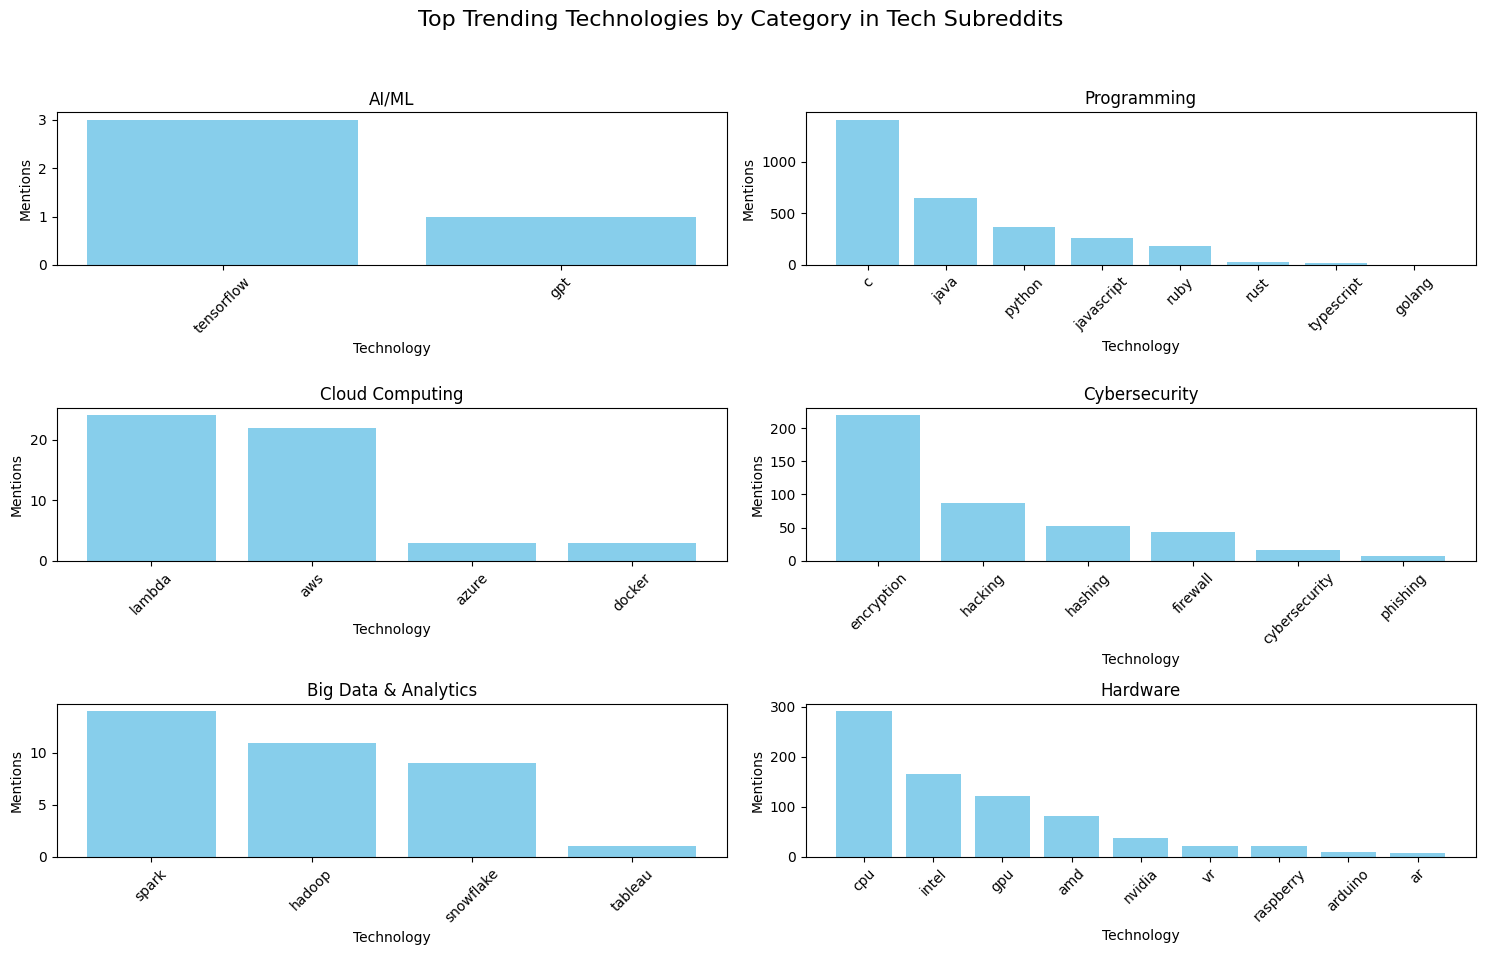

Execution Time with 4 executors: 207.79 seconds


Partitions used: 1


Executors: 8, Worker nodes: 8


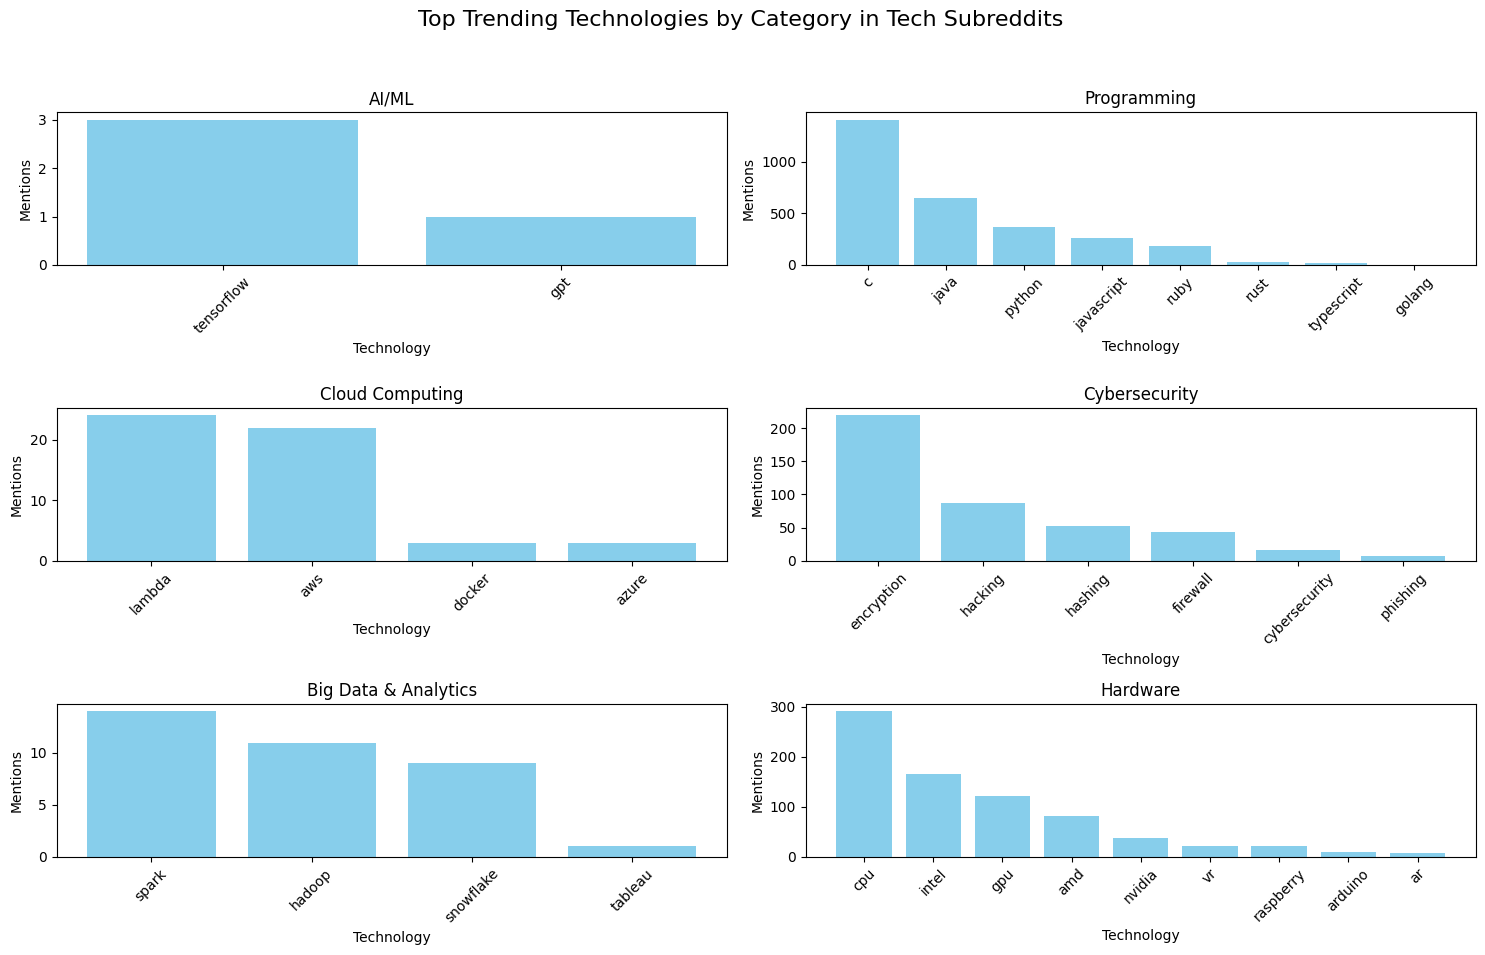

Execution Time with 8 executors: 172.35 seconds


Partitions used: 1


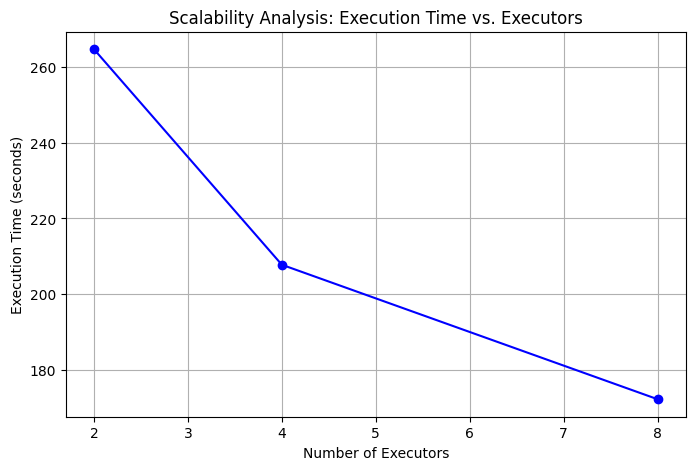

In [1]:
from pyspark.sql import SparkSession
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StopWordsRemover

def run_experiment(num_executors):
    # Initialize Spark Session with dynamic executor configuration
    spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName(f"Project_22_Ville_Holma_{num_executors}_executors")\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.executor.memory", "4g")\
        .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.2.156:9000") \
        .config("spark.cores.max", 8)\
        .config("spark.executor.instances", num_executors)\
        .config("spark.executor.cores", max(1, 8 // num_executors))\
        .getOrCreate()
    
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")
    
    # Load dataset from HDFS
    reddit_path = "hdfs://192.168.2.156:9000/data/reddit"
    df_original = spark_session.read.json(reddit_path)
    
    # Start timing execution
    start_time = time.time()
    df = df_original.sample(fraction=0.5, seed=0)
    num_workers = spark_context._jsc.sc().getExecutorMemoryStatus().size() - 1
    print(f'Executors: {num_executors}, Worker nodes: {num_workers}')
    
    # Filter for Tech-Related Subreddits
    tech_subreddits = ["technology", "programming", "datascience", "MachineLearning", "AI"]
    df_filtered = df.filter(df.subreddit.isin(tech_subreddits))
    
    # Text cleaning function
    def clean_text(text):
        if text:
            text = text.lower()
            text = re.sub(r'[^a-z\s]', '', text)
            return text.split()
        return []
    
    # Register UDF and apply text cleaning
    clean_text_udf = udf(clean_text, ArrayType(StringType()))
    df_cleaned = df_filtered.withColumn("cleaned_body", clean_text_udf(col("body")))
    
    # Remove stopwords
    remover = StopWordsRemover(inputCol="cleaned_body", outputCol="filtered_words")
    df_final = remover.transform(df_cleaned)
    
    # Extract words and compute word frequency
    df_words = df_final.withColumn("word", F.explode(F.col("filtered_words")))
    df_word_counts = df_words.groupBy("word").count().orderBy(F.desc("count"))
    
    # Categorize words based on technology domains
    tech_categories = {
        "AI/ML": ["tensorflow", "pytorch", "scikit", "keras", "fastai", "huggingface", "gpt"],
        "Programming": ["python", "java", "javascript", "typescript", "c", "c++", "rust", "golang", "ruby"],
        "Cloud Computing": ["aws", "azure", "gcp", "kubernetes", "docker", "lambda", "serverless"],
        "Cybersecurity": ["cybersecurity", "hacking", "ransomware", "phishing", "encryption", "firewall", "hashing"],
        "Big Data & Analytics": ["hadoop", "spark", "kafka", "snowflake", "databricks", "powerbi", "tableau"],
        "Hardware": ["gpu", "cpu", "nvidia", "amd", "intel", "raspberry", "arduino", "iot", "vr", "ar"]
    }
    
    df_tech_words = df_words.filter(df_words.word.isin(
        [word for category in tech_categories.values() for word in category]
    ))
    
    df_word_counts_by_category = df_tech_words.groupBy("word").count().orderBy(F.desc("count"))
    
    # Convert to Pandas for plotting
    df_pandas = df_word_counts_by_category.toPandas()
    category_trends = {category: df_pandas[df_pandas["word"].isin(words)].sort_values("count", ascending=False)
                       for category, words in tech_categories.items()}
    
    # Plot results
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle("Top Trending Technologies by Category in Tech Subreddits", fontsize=16)
    axes = axes.flatten()
    
    for i, (category, df_trend) in enumerate(category_trends.items()):
        if not df_trend.empty:
            axes[i].bar(df_trend["word"], df_trend["count"], color="skyblue")
            axes[i].set_title(category)
            axes[i].set_xlabel("Technology")
            axes[i].set_ylabel("Mentions")
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].set_title(category)
            axes[i].text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"Execution Time with {num_executors} executors: {total_time:.2f} seconds")
    print(f'Partitions used: {df_word_counts.rdd.getNumPartitions()}')
    
    spark_session.stop()
    return total_time

# Experiment with different executor counts
executor_counts = [2, 4, 8]
execution_times = [run_experiment(num_executors) for num_executors in executor_counts]

# Plot scalability results
plt.figure(figsize=(8, 5))
plt.plot(executor_counts, execution_times, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Executors")
plt.ylabel("Execution Time (seconds)")
plt.title("Scalability Analysis: Execution Time vs. Executors")
plt.grid(True)
plt.show()
